[Download this page](IRIS.ipynb) as a Jupyter notebook.

# IRIS and AIA

To work with IRIS data in Python we will make use of the [IRISPy](http://docs.sunpy.org/projects/irispy/en/latest/) package. IRISPy is an affiliated package of SunPy.

## Initialisation

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon

import numpy

from irispy.sji import read_iris_sji_level2_fits

import sunpy.map
from sunpy.instr.aia import aiaprep
from sunpy.time import parse_time

from astropy.coordinates import SkyCoord
from astropy import units as u

# To make a larger figure
plt.rcParams['figure.figsize'] = [10, 9]

import warnings
warnings.filterwarnings("ignore")

## Working with IRIS SJI files

Let us start by loading the IRIS dataset that was taken at a similar time to the AIA images we worked on earlier. IRIS has both a spectrograph and an imager, but here we'll work only with the imager (SJI = Slit-Jaw Image). These images show the position of the spectrograph slit with respect to the solar image. The slit is the central, vertical dark line in the images.  

To read IRIS SJI files, we'll make use of the `read_iris_sji_level2_fits` from `IRISPy`:

In [2]:
sji = read_iris_sji_level2_fits("iris_l2_20140919_051712_3860608353_SJI_2832_t000.fits")
sji

INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]



    IRISMapCube
    ---------
    Observatory:		 IRIS
    Instrument:			 SJI
    Bandpass:			 2832.0
    Obs. Start:			 2014-09-19T05:17:12.610000
    Obs. End:			 2014-09-19T07:14:54.895000
    Instance Start:		 2014-09-19T05:17:31.110000
    Instance End:		 2014-09-19T07:13:24.610000
    Total Frames in Obs.:	 65
    IRIS Obs. id:		 3860608353
    IRIS Obs. Description:	 Large sit-and-stare 0.3x120 1s  C II   Mg II h/k   Mg II w s Deep x
    Cube dimensions:		 [ 65. 387. 364.] pix
    Axis Types:			 (None, 'custom:pos.helioprojective.lat', 'custom:pos.helioprojective.lon')
    

This loads the data into an `IRISMapCube` object. Unlike AIA, an IRIS SJI file contains many images. In the summary above, we can see that this sequence on 2014-09-19 goes from 05:17:31 to 07:13:24 and contains 65 images. Each image has dimensions of (nx, ny) = (387, 364). Like `Map` in SunPy, `IRISMapCube` contains additional metadata, including the coordinates of the observation. It also has a `.plot()` method, that allows a quick plotting of images:

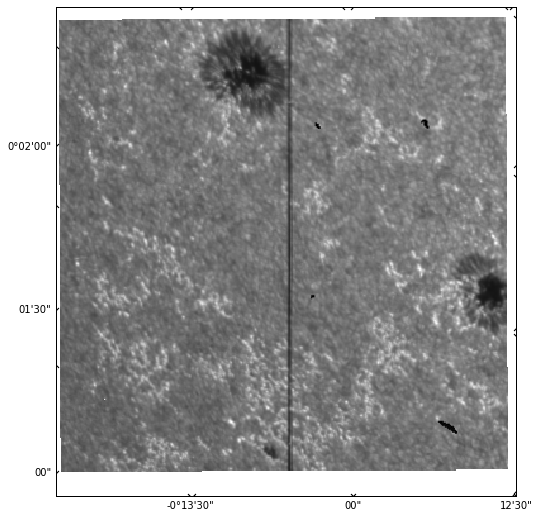

In [5]:
sji[0].plot()
plt.show()

Here, we are plotting the first image in the sequence. It is also possible to simply call `sji.plot()`, which will return an animator instance that can play a movie of all images when an interactive matplotlib backend is used (here we are using `inline`, which works better in the browser, but is not interactive).

The plot does not look as complete as `sunpy.map.Map.plot()` because IRISPy is still a very new package and does not have all the features in SunPy. In the above we can see that the time of the observation is not shown, and the coordinate axes are not labelled and they appear in degrees/minutes/arcseconds instead of just arcseconds. We can manually create a more complete plot: 

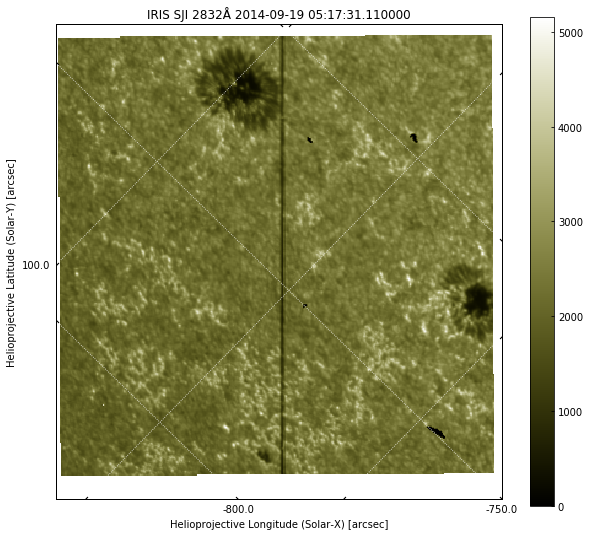

In [163]:
# Use WCS coordinates, but drop last axis (time)
ax = plt.subplot(projection=sji.wcs.dropaxis(-1))
img = ax.imshow(sji[0].data, cmap='irissji2832', vmin=0)
ax.coords[0].set_major_formatter('s.s')
ax.coords[1].set_major_formatter('s.s')
ax.grid(color='w', ls=':')
ax.set_xlabel("Helioprojective Longitude (Solar-X) [arcsec]")
ax.set_ylabel("Helioprojective Latitude (Solar-Y) [arcsec]")
ax.set_title("IRIS SJI %.0fÅ %s" % (sji.meta['TWAVE1'],
                                    sji.extra_coords['TIME']['value'][0]))
plt.colorbar(img, ax=ax)
plt.show()

Now we have a plot that is much closer to that of SunPy map. 

!!! info "What is different between IRIS and AIA images?"
    The image above is different from the AIA images in many ways:
    
    * We have only a small field-of-view and not the whole disk, but higher spatial resolution
    * There is a vertical black line (the IRIS slit)
    * The coordinate axes and grid are not always aligned with the 
      image axes because IRIS can be rotated (rolled) for observations. 
      In this case the roll is about 45º
    * There is a white border around the image with a slight tilt.
      These are CCD pixels that are not exposed to solar light, and in some 
      cases can also be padding for the full size of a raster.
    
## Using AIA for context

We can use IRIS to zoom in on the small details, and AIA to get a global view. Let us look at an AIA image and see the region surrounding the IRIS field-of-view. We will use the first AIA 1700Å image we downloaded earlier in the AIA exercises, with a file name of `aia_20140919_060030_1700_image_lev1.fits`, that should be in `~/sunpy/data` (if you don't have it, please run the SunPy exercise again). Please adjust the following to make sure it reflects the path in your computer:

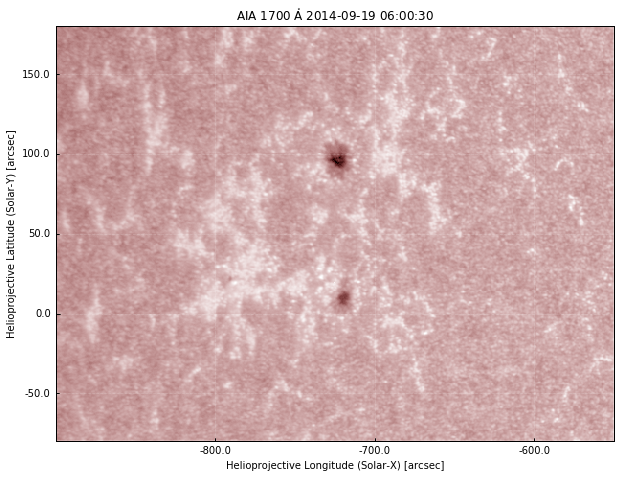

In [63]:
aia_file = '/Users/tiago/sunpy/data/aia_20140919_060030_1700_image_lev1.fits'
tmp = sunpy.map.Map(aia_file)
aia = aiaprep(tmp)

# create a submap around the sunspots
top_right = SkyCoord(-550*u.arcsec, 180*u.arcsec, frame=aia.coordinate_frame)
bottom_left = SkyCoord(-900 * u.arcsec, -80. * u.arcsec, frame=aia.coordinate_frame)
aia_sub = aia.submap(top_right, bottom_left)
aia_sub.plot()
plt.show()

This is what we saw earlier. Now let's plot the IRIS field of view on the AIA image using the information from the WCS coordinates. We will use the method `pixel_to_world` to convert from pixels to WCS coordinates, and then plot a polygon using the coordinates of the 4 corners of the IRIS image:

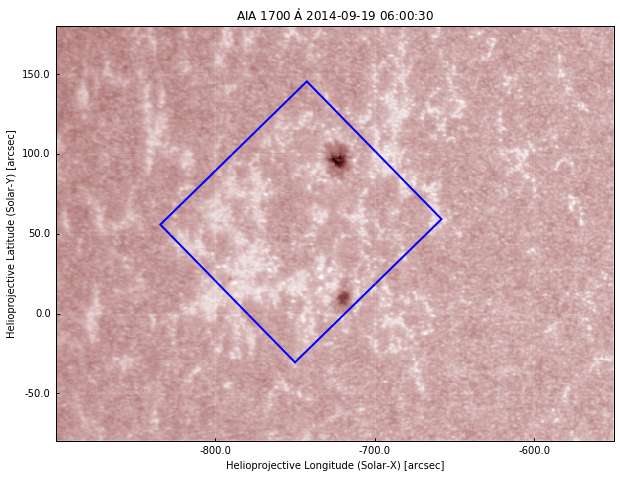

In [64]:
aia_sub.plot()
ax = plt.gca()
dims = sji.data.shape
_, ypts, xpts = sji.pixel_to_world(numpy.zeros(4) * u.pix, 
                                   [0, dims[1] - 1, dims[1] -1 , 0] * u.pix,
                                   [0, 0, dims[2] - 1, dims[2] - 1] * u.pix)
iris_points = numpy.array([xpts.value, ypts.value, ]).T
r = Polygon(iris_points, closed=True, edgecolor='b', facecolor='none', lw=2,
            transform=ax.get_transform('world'))
ax.add_patch(r)
plt.show()

So now we have the blue square showing the region of the IRIS observations. If we compare with the IRIS image above, this seems right: we capture both sunspots, and one of them is close to the edge. To work with both IRIS and AIA data, it helps if the image axes are aligned, and for this we need to rotate one of them. We can either rotate AIA to the IRIS frame, or vice-versa. Generally, it is easier to rotate AIA to IRIS because IRIS images are higher resolution and the files contain a sequence of images. Let's do that, again using the WCS coordinates of both objects. First, we rotate the AIA map using the inverse rotation of the IRIS frame:

In [ ]:
aia_rot = aia.rotate(rmatrix=numpy.matrix(sji.wcs.wcs.pc[:-1, :-1]).I)

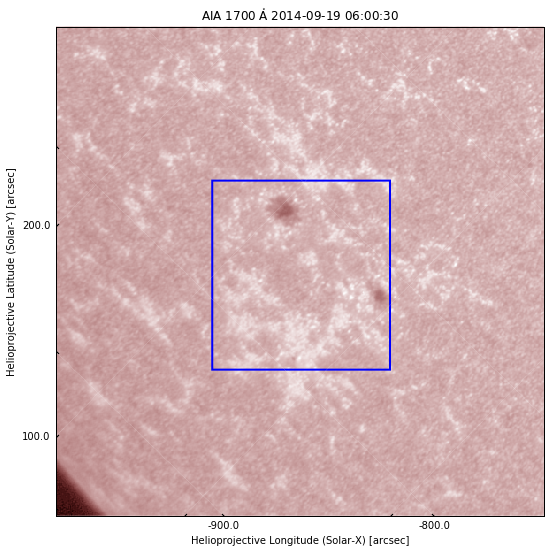

In [168]:
# Create submap on rotated image, with slightly smaller lower field of view
top_right = SkyCoord(-610*u.arcsec, 160*u.arcsec, frame=aia_rot.coordinate_frame)
bottom_left = SkyCoord(-880 * u.arcsec, -40. * u.arcsec, frame=aia_rot.coordinate_frame)
aia_rot_sub = aia_rot.submap(top_right, bottom_left)
aia_rot_sub.plot()
# add the same IRIS field-of-view:
ax = plt.gca()
r = Polygon(iris_points, closed=True, edgecolor='b', facecolor='none', lw=2,
            transform=ax.get_transform('world'))
ax.add_patch(r) 
plt.show()

We can now see that the IRIS field-of-view appears as a straight square, because we rotated the view so the image axes of AIA and IRIS coincide. Here we show a submap of AIA to see a larger region around the IRIS observations.

??? question "Can you make an AIA submap be the same field-of-view as IRIS?"
    Above, we define two coordinates, `top_right` and `bottom_left` (from `Skycoord`, in arcsec). So to make an AIA submap be exactly the same field-of-view as IRIS, we just need to change `top_right` and `bottom_left` to be the limits of the IRIS image. We already have these IRIS coordinates when we plot the blue square, so we just need to find which ones are the bottom left and top right corners and put them on a `SkyCoord` object. In this case, it is: 
    
    ``` python
    top_right = SkyCoord(xpts[0], ypts[0], frame=aia_rot.coordinate_frame)
    bottom_left = SkyCoord(xpts[-2], ypts[-2], frame=aia_rot.coordinate_frame)
    ```

## Putting everything together

We have seen how to load an IRIS image, and how to plot its field-of-view on top of an AIA image. Now we are going to directly compare IRIS with AIA.

First, we need to make sure we compare images taken at similar times, because the solar atmosphere evolves quickly. The AIA image above was taken on 2014-09-19 06:00:30. How do we find the IRIS image closest in time?

The observing time for each IRIS image is saved under `sji.extra_coords['TIME']`.

Let us start by finding out the time of this observation. The time each frame was acquired is saved under `sji.extra_coords['TIME']`, and the AIA observing time is saved in `.meta['date-obs']`:

In [114]:
# convert AIA time from string to datetime
aia_time = parse_time(aia_rot_sub.meta['date-obs'])
iris_times = sji.extra_coords['TIME']['value']
# Now get the difference between AIA and IRIS times
time_diff = aia_time - iris_times
# and the index with the lowest difference
time_index = numpy.argmin(numpy.abs(time_diff))

print("AIA time:  %s\nIRIS time: %s" % (aia_time, iris_times[time_index]))

AIA time:  2014-09-19 06:00:30.711610
IRIS time: 2014-09-19 06:00:58.670000


We see that the closest IRIS time is about 28 seconds after the AIA observation, which is ok. We can now plot the IRIS and AIA side by side:

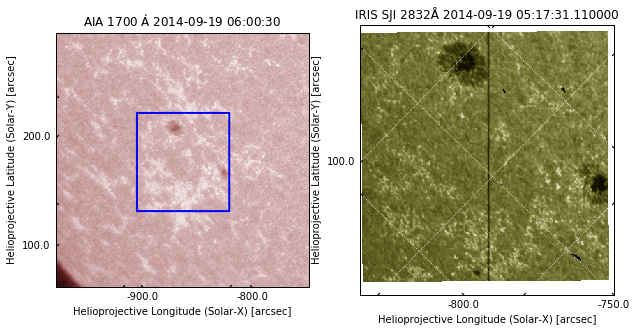

In [178]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1, projection=aia_rot_sub)
aia_rot_sub.plot()
r = Polygon(iris_points, closed=True, edgecolor='b', facecolor='none', lw=2,
            transform=ax1.get_transform('world'))
ax1.add_patch(r) 

ax2 = fig.add_subplot(1,2,2, projection=sji.wcs.dropaxis(-1))
img = ax2.imshow(sji[time_index].data, cmap='irissji2832', vmin=0)
ax2.coords[0].set_major_formatter('s.s')
ax2.coords[1].set_major_formatter('s.s')
ax2.grid(color='w', ls=':')
ax2.set_xlabel("Helioprojective Longitude (Solar-X) [arcsec]")
ax2.set_ylabel("Helioprojective Latitude (Solar-Y) [arcsec]")
ax2.set_title("IRIS SJI %.0fÅ %s" % (sji.meta['TWAVE1'],
                                    sji.extra_coords['TIME']['value'][0]))
plt.show()

## Measuring spatial scales

When analysing images, we often want to measure spatial scales in e.g. km. How do we convert from image pixels to km? And how to we measure image pixels? We have seen above that to convert from pixels to WCS coordinates we can make use of `.pixel_to_world`. For SunPy `Map` objects such as our AIA image, the output is a `SkyCoord` (we have only two dimensions):

In [364]:
c = aia_rot_sub.pixel_to_world(0 * u.pix, 0 * u.pix)
c

<SkyCoord (Helioprojective: obstime=2014-09-19 06:00:30.711610, rsun=696000000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2014-09-19 06:00:30.711610): (lon, lat, radius) in (deg, deg, m)
    (0., 7.1342492, 1.50333097e+11)>): (Tx, Ty) in arcsec
    (-979.39734017, 62.42308006)>

The solar X and Y coordinates in arcsec can be accessed by:

In [363]:
c.Tx, c.Ty

(<Longitude -979.39734017 arcsec>, <Latitude 62.42308006 arcsec>)

For `IRISMapCube` objects, the data have 3 dimensions (time being the first), and we must specify all:

In [365]:
sji.pixel_to_world(0 * u.pix, 0 * u.pix, 0 * u.pix)

[<Quantity 2506.4372 s>, <Quantity 0.01548156 deg>, <Quantity -0.23177934 deg>]

The output is in different `Quantity` objects, the first being the time since the start of the IRIS observation, followed by solar X and Y in degrees. 

Now let us assume that in the IRIS image, we want to calculate the distance between the sunspots. With coordinates, we can  overplot lines on top of the images (as we did previously with the IRIS field of view on AIA). Let us plot the IRIS image and plot the approximate coordinates between the centres of the sunspot (these were obtained by experimenting):

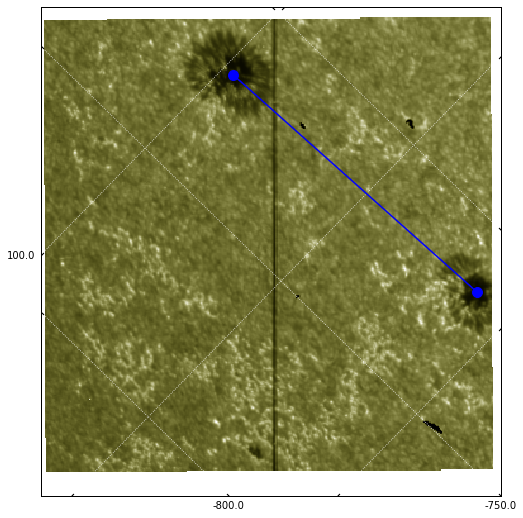

In [383]:
ax = plt.subplot(projection=sji.wcs.dropaxis(-1))
ax.imshow(sji[0].data, cmap='irissji2832', vmin=0)
ax.coords[0].set_major_formatter('s.s')
ax.coords[1].set_major_formatter('s.s')
ax.grid(color='w', ls=':')

# approximate (x, y) coordinates of sunspots in arcsec
sunspot1 = [-720, 97] * u.arcsec   
sunspot2 = [-716, 11] * u.arcsec

# Must convert from arcsec to degrees because WCSAxes works always in degrees
sunspot_x = u.Quantity([sunspot1[0], sunspot2[0]]).to(u.deg)
sunspot_y = u.Quantity([sunspot1[1], sunspot2[1]]).to(u.deg)

# use get_transform('world') to plot in coordinate space
ax.plot(sunspots_x, sunspots_y, 'bo-',
        transform=ax.get_transform('world'),  ms=10)
plt.show()

Now that we have the coordinates, the distance between the sunspots is simply the euclidian distance:

$$
d = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}
$$

We can use `numpy.linalg.norm` to avoid having to type all those points by hand, and we get the distance in arcsec:

In [386]:
dist = numpy.linalg.norm(sunspot1 - sunspot2) * u.arcsec
dist

<Quantity 86.092973 arcsec>

In any case, a question remains: how to convert from coordinates (deg, arcsec) to distance in km?

!!! info "Angular vs linear distance"
    So far we are working with angular distances and not linear distances.
    When the angular size of an object is very small (less than 1º, as most astronomical objects), we can use
    the small angle approximation and relate the angular to linear distance: $d = \alpha D$, where
    $\alpha$ is the angular distance (in radians) and $D$ is the distance to the object (in our case, the Sun).
    
??? question "When is Earth closer to the Sun?"
    The distance between Earth and the Sun varies with time, because Earth's orbit is not perfectly circular. 
    The point when Earth is closest to the Sun is called *periapsis* and takes place approximately on January 3.
    The point when Earth is farthest from the Sun is called *apoapsis* and takes place approximately on July 3.

The distance between the Sun and Earth is 1 au, or 149.597 Gm, but this is the mean distance between perihelion and aphelion. The exact distance will depend on the time of our observations. Fortunately, SunPy has utility functions that we can use to calculate this:

In [394]:
from sunpy.coordinates import frames

# time of first IRIS image
obs_date = sji.extra_coords['TIME']['value'][0]

# get 1" interval at disk-centre between in cartesian coordinates 
a1 = SkyCoord(0 * u.arcsec, 0 * u.arcsec, frame='helioprojective',
              obstime=obs_date).transform_to('heliocentric').x
a2 = SkyCoord(1 * u.arcsec, 0 * u.arcsec, frame='helioprojective',
              obstime=obs_date).transform_to('heliocentric').x
asec_to_Mm = (a2 - a1).to(u.Mm)
asec_to_Mm

<Quantity 0.72526922 Mm>

So we see that in this date, 1${}^{\prime\prime}$ is about 725.26922 km. We can use this to convert the distance between the sunspots and get the final result in Mm:

In [395]:
dist_Mm = dist.value * asec_to_Mm
dist_Mm

<Quantity 62.44058305 Mm>